# TyBox (quantized FE) with CNAS baseline model: Concept Drift scenario

This Notebook shows the use of the extended version of TyBox that implements full-integer quantization (https://github.com/pavmassimo/TyBox/tree/feature-extractor-quantization) on a CNAS-designed architecture (https://github.com/matteogambella/NAS) for the generation of an incremental solution able to address a concept drift.

The CIFAR-10 dataset was used to prove the capabilities of the toolbox. Two classes in the dataset have been swapped to simulate a concept drift.

A full description of the experiment is provided in the Master Thesis executive summary present in the GitHub repository.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K 
K.set_image_data_format('channels_last')

from sklearn.preprocessing import OneHotEncoder

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('.//TyBox')

from TyBox import TyBox
from TyBox import profiler


from matplotlib import pyplot as plt

## Download and preparation of the dataset

In [3]:
from keras.datasets import cifar10
# Load data 
(train_examples, train_labels), (test_examples, test_labels) = cifar10.load_data()

train_examples = train_examples.astype('float32')
test_examples = test_examples.astype('float32')

train_examples = train_examples / 255.0
test_examples = test_examples / 255.0

# # One hot encode target values
# train_labels = np_utils.to_categorical(train_labels)
# test_labels = np_utils.to_categorical(test_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

170498071/170498071 [==============================] - 13s 0us/step


## Load model

In [4]:
model = keras.models.load_model("pruned_CNAS_model")

In [5]:
# Compile model
pruning_lrate = 0.00135
pruning_adam = tf.keras.optimizers.Adam(learning_rate=pruning_lrate)

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=pruning_adam, metrics=['accuracy'])

#### Model summary

In [6]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   432         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 16)   0           ['batch_normalization[0][0]

## Network Profiler
It is possible now to initialize the profiler with the defined model.
The profiler can provide useful information to the designer of the network on the memory occupations in terms of weights and activations, in total and at a per-layer granularity. 

In [7]:
# profiler = profiler.Profiler("model", model)
profiler = profiler.Profiler(network_name="model", model=model, precisions=[[8, 8], [32, 32]])

<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc28ea19150>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc28e9b0390>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc28e9c0b50>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc28e98ce90>
create_l
<class 'keras.layers.core.activation.Activation'

In [8]:
profiler.print_occupations()

total parameters fe:  1146867
total parameters classification head: 3810
total parameters:  1150677
peak activations fe: 24576
peak activations classification head: 770
peak activations total: 25346
total parameters fe mem:  1146867.0 B
total parameters classification head mem: 15240.0 B
total parameters mem: 1162107.0 B
peak activations fe mem: 24576.0 B
peak activations classification head mem: 3080.0 B
peak activations total mem: 27656.0 B


In [9]:
profiler.print_per_layer()

InputLayer
memory = {'param': 0, 'act': 1}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
Conv2D
memory = {'param': 432, 'act': 4096}
operations = {'flops': 219108.0, 'maccs': 115320.0, 'divisions': 0, 'sums': 0, 'comparisons': 0}
BatchNormalization
memory = {'param': 64, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
swish
memory = {'param': 0, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
Conv2D
memory = {'param': 144, 'act': 4096}
operations = {'flops': 351232.0, 'maccs': 31360.0, 'divisions': 0, 'sums': 0, 'comparisons': 0}
BatchNormalization
memory = {'param': 64, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
relu
memory = {'param': 0, 'act': 4096}
operations = {'flops': 0, 'maccs': 0, 'divisions': 0, 'sums': 0, 'comparisons': 4096}
Conv2D


## Introduce concept drift: class swap

In the data used for incremental training and testing, class 4 and 6 are swapped to simulate an abrupt concept drift.


In [10]:
def swap_class(num):
    if num == 4:
        return 6
    elif num == 6:
        return 4
    else:
        return num

test_inverted_labels = np.array([swap_class(item) for item in test_labels]).astype('float32')
test_inverted_dataset = tf.data.Dataset.from_tensor_slices((tf.experimental
                        .numpy.expand_dims(test_examples, -1), test_inverted_labels))
test_inverted_dataset = test_inverted_dataset.batch(BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


In [11]:
model.evaluate(test_dataset)
model.evaluate(test_inverted_dataset)

157/157 [==============================] - 36s 222ms/step - loss: 1.3363 - accuracy: 0.6439


[1.336254358291626, 0.6438999772071838]

## Python Incremental solution

To generate the python version of the incremental solution, it's sufficient to call 

*Tybox.create_python_learning_solution(tf_model, mem_available, precision)*

where mem_available is the amount of memory that can be dedicated to the machine learning on device (in Bytes), and precision is data precision of model and activations in bit (currently TyBox support only 32-bit floating point precision).


In [12]:
## Mf_lite, Mc_python = TyBox.create_python_learning_solution(model, 9000000, 32)

# Create a compressible model for TFLite using integer-only quantization
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_examples).batch(1).take(500):
        yield [input_value]
yield_representative_dataset = representative_data_gen
Mf_lite, Mc_python = TyBox.create_python_learning_solution(model, 1250000, 8, yield_representative_dataset)

1/1 [==============================] - 0s 64ms/step


/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc28ea19150>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc28e9b0390>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc28e9c0b50>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc28e98ce90>
create_l
<class 'keras.layers.core.activation.Activation'

### Feature extraction with tf_lite

The tf_lite model is saved and used to extract the latent features from the data

In [13]:
with open("mf.tflite", "wb") as file:
    file.write(Mf_lite)

#tf-lite model preparation
interpreter = tf.lite.Interpreter('mf.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
print(input_details)
output_details = interpreter.get_output_details()[0]
print(output_details)

#feature extraction with the tf-lite model
test_feature = []
for i in range(len(test_labels)):
    input_data = test_examples[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    test_feature.append(interpreter.get_tensor(output_details['index']))
test_feature = np.array(test_feature)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 201, 'shape': array([  1, 380], dtype=int32), 'shape_signature': array([ -1, 380], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.10120552033185959, 3), 'quantization_parameters': {'scales': array([0.10120552], dtype=float32), 'zero_points': array([3], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [14]:
#generate one hot-encoding of labels
categorical_test_labels_inverted = np.zeros(shape=(10000, 10))
for i in range(len(test_labels)):
    categorical_test_labels_inverted[i][int(test_inverted_labels[i])] = 1

categorical_test_labels = np.zeros(shape=(10000,10))
for i in range(len(test_labels)):
    categorical_test_labels[i][test_labels[i]] = 1

### TyBox: python model usage

In [15]:
import random

#n of times the experiment will be repeated.
n_repetitions = 5

#n of data used in the experiment
exp_l = 1200

#time of the concept drift event
concept_drift_event_time = 100

accuracies_tb = []

for repetition in range(n_repetitions):
    #list to store the results
    res_acc = []

    #load the original model and convert it
    model = keras.models.load_model("pruned_CNAS_model")
    # fe_model, python_model = TyBox.create_python_learning_solution(model, 9000000, 32)
    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(train_examples).batch(1).take(500):
            yield [input_value]
    yield_representative_dataset = representative_data_gen
    fe_model, python_model = TyBox.create_python_learning_solution(model, 1250000, 8, yield_representative_dataset)
    python_model.set_lr(0.001)
    
    #fix seed for reproducibility
    random.seed(42 + repetition)

    #sample without repetition from the training dataset
    indices = random.sample(range(5000), exp_l)

    step = 0

    for sample in indices:
        datum = test_feature[sample]

        #before concept drift event
        if step < concept_drift_event_time:
          label = categorical_test_labels[sample]
          test = categorical_test_labels[5000:5200]

        #after concept drift event
        else:
          label = categorical_test_labels_inverted[sample]
          test = categorical_test_labels_inverted[5000:5200]

        #push datum into buffer and train on the whole buffer
        python_model.push_and_train(datum, label)

        #evaluate accuracy on test set
        accuracy = python_model.evaluate(test_feature[5000:5200], test, output_details["quantization"])
        res_acc.append(accuracy)

        print(step, accuracy)
        step += 1 
    accuracies_tb.append(res_acc)

1/1 [==============================] - 0s 61ms/step


/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc1848c6e50>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc1848c62d0>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc1848a6490>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc1840aa210>
create_l
<class 'keras.layers.core.activation.Activation'

/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc160db3450>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc1601e12d0>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc1601f2350>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc160ecd710>
create_l
<class 'keras.layers.core.activation.Activation'

/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc15d94c390>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc15d94cdd0>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc15ed17390>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc15ed24890>
create_l
<class 'keras.layers.core.activation.Activation'

/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc157fd9ad0>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc159c128d0>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc159c0d690>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc159c2a650>
create_l
<class 'keras.layers.core.activation.Activation'

/opt/conda/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


<class 'keras.engine.input_layer.InputLayer'>
evaluating <keras.engine.input_layer.InputLayer object at 0x7bc15490e690>
create_l
<class 'keras.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_1 InputLayer  is not supported
InputLayer
<class 'keras.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.layers.convolutional.conv2d.Conv2D object at 0x7bc1547f3210>
create_l
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7bc15490e110>
create_l
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization BatchNormalization  is not supported
BatchNormalization
<class 'keras.layers.core.activation.Activation'>
evaluating <keras.layers.core.activation.Activation object at 0x7bc154306590>
create_l
<class 'keras.layers.core.activation.Activation'

In [16]:
avg_accuracies_tb = []
for i in range(len(accuracies_tb[0])):
  avg = 0
  for ii in range(len(accuracies_tb)):
    avg += accuracies_tb[ii][i]
  avg = avg / len(accuracies_tb)
  avg_accuracies_tb.append(avg)

In [17]:
import math

std_dev_accuracies_tb = []
for i in range(len(avg_accuracies_tb)):
  std_dev = 0
  for ii in range(len(accuracies_tb)):
    std_dev += (avg_accuracies_tb[i] - accuracies_tb[ii][i]) ** 2
  std_dev = math.sqrt(std_dev / len(accuracies_tb))
  std_dev_accuracies_tb.append(std_dev)

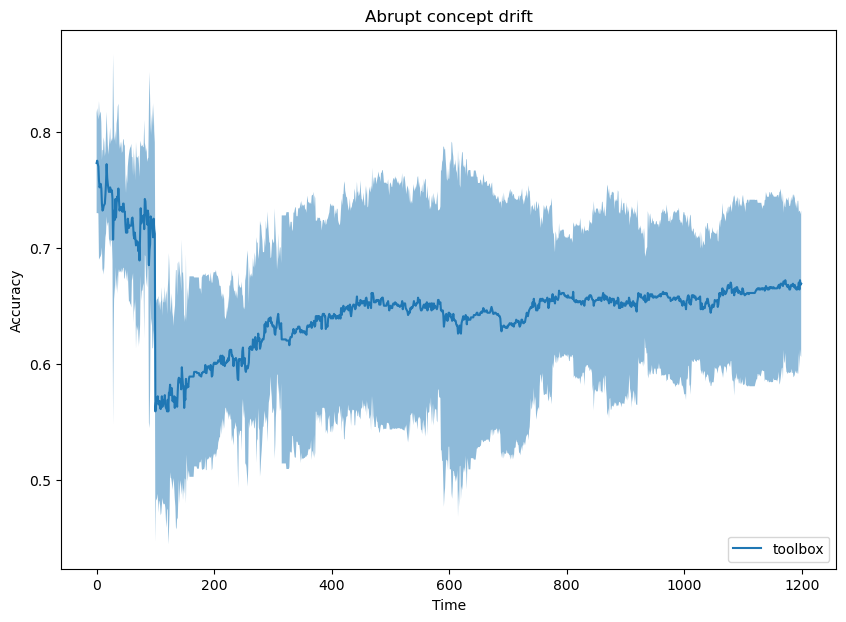

In [18]:
plt.figure(figsize=(10,7))

plt.plot(avg_accuracies_tb, label="toolbox")
std_low = [avg_accuracies_tb[i] - 2*std_dev_accuracies_tb[i] for i in range(len(avg_accuracies_tb))]
std_high = [min(avg_accuracies_tb[i] + 2*std_dev_accuracies_tb[i], 1) for i in range(len(avg_accuracies_tb))]
plt.fill_between([i for i in range(exp_l)], std_low, std_high, alpha=0.5)

plt.title("Abrupt concept drift")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend(loc=4)